# Exercise Sheet Week 12 - Practical: Variational inference

The exercise consists of three independent parts.

Part 2 is optional (see comment at the beginning of part 2).

In [126]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import multivariate_normal

import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn

from pyro.infer import Predictive
from pyro.infer import MCMC, NUTS
import torch

#imports 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython import display
import os
from PIL import Image
from torch.utils.data.dataset import Dataset
import scipy
import torch.nn.functional as nnf
from torch.optim import SGD 
import pyro
from pyro.distributions import Normal, Categorical
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import yfinance as yf
import matplotlib.pyplot as plt
import time
import fastprogress
import seaborn as sns
from pyro.nn import PyroModule, PyroSample



# Part 1: Joint likelihood, Marginal likelihood and ELBO.

In this part, we will illustrate how the evidence of a statistical model, obtained by integrating out the parameters of the model, is a measure of model fit that takes into account the uncertainty in the estimated variables and predicts generalization performance.

## Data

We are interested in modelling the following time series:

In [127]:
values = np.loadtxt('data_12_1.csv')

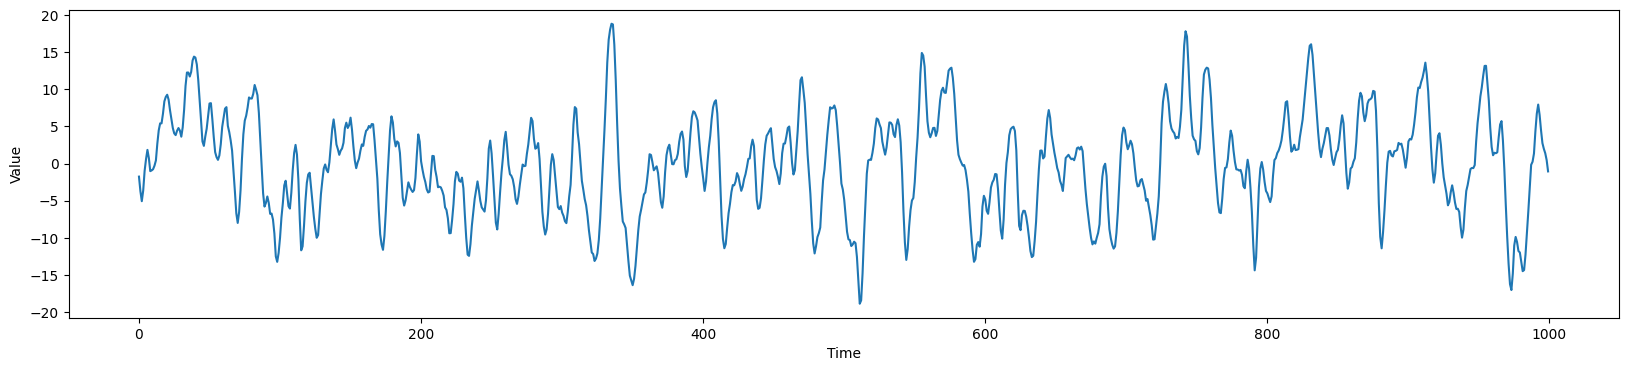

In [128]:
values = np.loadtxt('data_12_1.csv')

plt.figure(figsize=(20, 4))
plt.plot(values)
plt.ylabel('Value')
plt.xlabel('Time')
None

#print(values)

## Model

We will model this time series with a simple autoregressive model. This, means, we assume the observation $X_t$ for a time point $t$ can be predicted by a linear combination of the last $k$ preceding observations for some $k >0$:
$$
    X_t = w_1 X_{t-1} + \ldots + w_k X_{t-k} + \epsilon_t
$$
the parameters of the model are then the weights $w_1, \ldots, w_k$.

The noise $\epsilon_t$ can be any continuous random variable. A common choise is a gaussian noise, which introduces a new scale parameter. Here, we then place an inverse prior on the scale and integrate it out, resulting in a reasonable model without additional parameters. The corresponding likelihood will be given below (*we will not make use of any knowledge about this distribution in the exercise*).

Most importantly, this model has an an hyper-parameter $k$ that controls how many past observations are used. For $k = 1$, we only use the last observation $X_{t-1}$ to predict $X_t$, and the model has a single parameter $w_1$ ; as $k$ increases, we use more and more features to predict the next observations and the model has more and more weights.

For Bayesian interpretation, we consider the prior $p(\mathbf{w} | k)$ to be a flat prior on $\mathbb{R}^k$ (or equivalently on $\{\mathbf{w} \in \mathbb{R}^{\mathbb{N}^*}, \forall i > k, w_i = 0\})$ ; or yet the product of flat priors for $w_i, i \leq k$ and diracs at 0 for $w_i, i > k$).

We start by generating the features (which are simply the time series itself, but shifted in time) and splitting the data into a training and test set:

In [129]:
def make_lags(array, max_lag):
    return np.stack([ array[max_lag-lag:len(array)-lag] for lag in range(max_lag+1) ])
max_lag = 5

lagged_values = make_lags(values, max_lag)

# Original data length
data_length = len(values)

# Set the percentage of data for training
train_percentage = 0.8

# Calculate the number of training samples
n_train = int(data_length * train_percentage)


lagged_training_values = lagged_values[:, :n_train]
lagged_test_values = lagged_values[:, n_train:]

In [130]:
print((values).shape)
print(lagged_values.shape)
print(values)

(1000,)
(6, 995)
[-1.75786292e+00 -3.71148390e+00 -5.07030539e+00 -3.62272825e+00
 -9.83265210e-01  6.09020698e-01  1.84497145e+00  7.45510683e-01
 -1.01922411e+00 -9.19694905e-01 -7.58986232e-01 -2.83241120e-01
  4.24855528e-01  2.68176044e+00  4.47488026e+00  5.42256777e+00
  5.41927207e+00  6.71565524e+00  8.38785752e+00  8.98494794e+00
  9.27936012e+00  8.61881225e+00  7.19089344e+00  6.00415611e+00
  4.78476073e+00  4.07009019e+00  3.83786027e+00  4.42565649e+00
  4.79074331e+00  4.44621626e+00  3.62272414e+00  4.87943007e+00
  7.25604440e+00  1.04632476e+01  1.22742413e+01  1.22715261e+01
  1.17341800e+01  1.23578174e+01  1.38897960e+01  1.44232475e+01
  1.42892152e+01  1.33677664e+01  1.13077650e+01  8.66517041e+00
  5.81401805e+00  2.98367716e+00  2.38552885e+00  3.64564823e+00
  4.71189732e+00  6.44927077e+00  8.09786893e+00  8.14609160e+00
  5.99899837e+00  3.59946269e+00  1.53913216e+00  8.66785492e-01
  5.01005971e-01  1.09940756e+00  2.63691340e+00  4.94627145e+00
  6.1745

In [131]:
#print(lagged_values[0].shape)
#print(lagged_values[1:len(weight_sets)+1])

print(lagged_values[0].shape)
print(lagged_values[1:].shape)

(995,)
(5, 995)


In [132]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps
        if end_ix >= len(sequences):
            break
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


def multi_time(data, n_input, n_out):
    
    #train = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    X,y = list(), list()
    in_start= 0
    
    for i in range(len(data)):
        
        in_end = in_start + n_input
        out_end = in_end + n_out
        if out_end <= len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[in_end:out_end, 0])
            in_start +=1
    return np.array(X), np.array(y)

        
    

def data_processing(tickers,start, end, target, n_steps, multi_step= False, n_input=None, n_out = None):
    
    #tickers: a list of symbols to retrieve from stock market
    # start: starting date
    # end: ending date
    # target: dependent variable
    # n_steps: how many steps should be used to forecast
    # n_input: integer how many days used to make prediction
    # n_out: for how many days to predict

    # Notizen für Sönnie:
    # n_steps entspricht m aus dem paper, falls wir nur einen einen Schritt in die Zukunft predicten (also multi_step = False ist)
    # n_input entspricht m aus dem paper
    # n_out entspricht n aus dem paper
    # 
    
    
    data_list = []
   
    
    for symbol in tickers:
        stock_data = yf.download(symbol, start=start, end=end)
        data_close = stock_data.loc[:,"Close"]
        data_norm = (data_close - min(data_close)) / (max(data_close)-min(data_close)) #normalize
        data = data_norm.values.reshape((len(data_norm),1))
        data_list.append(np.array(data))
        
    target_data = yf.download(target, start=start, end=end)
    target_close = target_data.loc[:,"Close"]
    target_norm = (target_close - min(target_close)) / (max(target_close)-min(target_close))
    target = target_norm.values.reshape((len(target_norm),1))
      
    stacked_data = np.concatenate(data_list, axis=0)
    dataset = np.append(stacked_data,target ,axis=1)
    #print(dataset.shape)
    #print(dataset)
    
    if multi_step and n_input is not None and n_out is not None:
        
        X,y = multi_time(dataset, n_input, n_out)
        
    else:
        
        X,y= split_sequences(dataset, n_steps)
    
    return X,y, data_norm, 



In [133]:
days_to_consider = 14
days_to_forecast = 7

X,y, data_close = data_processing(['CL=F'],"2023-01-01","2024-01-01",'CL=F',5, multi_step=True, n_input=days_to_consider, n_out = days_to_forecast)
print(X.shape, y.shape)
# summarize the data
#print(X[2], y[2])
#print(X[3], y[3])
print(timeseries)

X = X[:,:,0] ### keine Ahnung warum die bekackte spalte doppelt sein sollte

X_train = X[:-days_to_forecast]
X_test = X[-days_to_forecast:]
y_train = y[:-days_to_forecast]
y_test = y[-days_to_forecast:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print(X.shape)
y_train

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

(231, 14, 2) (231, 7)


NameError: name 'timeseries' is not defined

In [ ]:
days_to_consider = 56
days_to_forecast = 28

X,y, data_close = data_processing(['CL=F'],"2022-01-01","2024-01-01",'CL=F',5, multi_step=True, n_input=days_to_consider, n_out = days_to_forecast)
print(X.shape, y.shape)
# summarize the data
#print(X[2], y[2])
#print(X[3], y[3])
#print(timeseries)

X = X[:,:,0] ### keine Ahnung warum die bekackte spalte doppelt sein sollte

X_train = X[:-1]
X_test = X[-1:]
y_train = y[:-1]
y_test = y[-1:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print(X.shape)
y_train

In [ ]:
class MyBNN(PyroModule):
    def __init__(self, input_dim, hidden_dim, output_dim, autocorr_coef = 0.9):
        super(MyBNN, self).__init__()
        self.autocorr_coef = autocorr_coef
        self.linear1 = PyroModule[nn.Linear](input_dim, hidden_dim)
        self.linear1.weight = PyroSample(dist.Normal(0., 10.).expand([hidden_dim, input_dim]).to_event(2))
        self.linear1.bias = PyroSample(dist.Normal(0., 10.).expand([hidden_dim]).to_event(1))
        self.activation = nn.Tanh()  # or nn.ReLU() based on preference
        self.linear2 = PyroModule[nn.Linear](hidden_dim, output_dim)
        self.linear2.weight = PyroSample(dist.Normal(0., 10.).expand([output_dim, hidden_dim]).to_event(2))
        self.linear2.bias = PyroSample(dist.Normal(0., 10.).expand([output_dim]).to_event(1))

    def forward(self, x, y=None):
        x = self.activation(self.linear1(x))
        mu = self.linear2(x)
        sigma = pyro.sample("sigma", dist.Gamma(0.5, 1.))
        
        # Ensure sigma_tensor has at least one dimension
        sigma_tensor = torch.tensor(sigma).unsqueeze(-1)

        sigma_tensor = torch.tensor(sigma).unsqueeze(-1).repeat(1, mu.size(-1))  # Shape: [batch_size, output_dim]
        #cov_matrix = torch.diag_embed(sigma_tensor ** 2)  # Shape: [batch_size, output_dim, output_dim]
        
        # Sampling model: Construct covariance matrix
        n = output_dim
        cov_matrix = torch.eye(n)  # Initialize covariance matrix as identity matrix
                
        # Fill upper triangle of the covariance matrix with autocorrelation coefficient
        for i in range(n):
            for j in range(i + 1, n):
                cov_matrix[i, j] = self.autocorr_coef ** (j - i)
        
        # Make the covariance matrix symmetric
        cov_matrix = sigma * ( cov_matrix + cov_matrix.T - torch.diag(cov_matrix.diag()) )
        
        # Sampling model: Sample from multivariate normal distribution with mean mu and covariance cov_matrix
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.MultivariateNormal(mu, cov_matrix), obs=y)
       
        return mu


In [ ]:
import torch
from pyro.infer import NUTS, MCMC

# Convert data to PyTorch tensors
x_train = torch.from_numpy(X_train).float()  # Features
y_train = torch.from_numpy(y_train).float()  # Target

print(x_train.shape)
print(y_train.shape)

# Instantiate the BNN model
input_dim = x_train.shape[1]  # Number of lagged features
hidden_dim = 10  # Number of hidden units
output_dim = y_train.shape[1]   # Output dimension

output_dim = y_train.shape[1]  # Output dimension matches the number of target variables
model = MyBNN(input_dim, hidden_dim, output_dim, autocorr_coef = 0.9)

# Set Pyro random seed
pyro.set_rng_seed(42)

# Define Hamiltonian Monte Carlo (HMC) kernel
nuts_kernel = NUTS(model)

# Define MCMC sampler, get 50 posterior samples
mcmc = MCMC(nuts_kernel, num_samples=50)

# Run MCMC
mcmc.run(x_train, y_train)


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from pyro.infer import Predictive

# Assuming `model` and `mcmc` are defined earlier

# Define your model, initialize MCMC, and run MCMC as shown in your previous code

# Assuming `X` contains your test features
x_test = torch.from_numpy(X_test).float()  # Features
print(X_test.shape)
print(y_test.shape)
# Create a predictive instance using the trained model and posterior samples
predictive = Predictive(model=model, posterior_samples=mcmc.get_samples())

# Obtain predictions for the test features
preds = predictive(x_test)

# Extract the mean predictions
mean_preds = preds['obs'].mean(dim=0)

std_preds = preds['obs'].std(dim=0) 

print(mean_preds.shape)
print(y_test.shape)
print(std_preds.shape)
print(mean_preds)
print(y_test)


In [ ]:
import torch

def elongate(matrix):
    num_rows, num_cols = matrix.shape
    new_num_cols = num_cols + num_rows - 1
    elongated_matrix = torch.zeros((num_rows, new_num_cols), dtype=matrix.dtype)
    for i in range(num_rows):
        elongated_matrix[i, i:i+num_cols] = matrix[i]
    return elongated_matrix

In [ ]:
def unnormalize_tensor(tensor, min_val, max_val):
    """
    Unnormalizes a tensor using the provided minimum and maximum values.

    Args:
    - tensor (torch.Tensor): The input tensor to unnormalize.
    - min_val (float): The minimum value of the original data.
    - max_val (float): The maximum value of the original data.

    Returns:
    - torch.Tensor: The unnormalized tensor.
    """
    return tensor * (max_val - min_val) + min_val
min_val = min(data_close)
max_val = max(data_close)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from pyro.infer import Predictive

# Assuming `model` and `mcmc` are defined earlier

# Define your model, initialize MCMC, and run MCMC as shown in your previous code

# Assuming `X` contains your test features
x_test = torch.from_numpy(X_test).float()  # Features
print(X_test.shape)
print(y_test.shape)
# Create a predictive instance using the trained model and posterior samples
predictive = Predictive(model=model, posterior_samples=mcmc.get_samples())

# Obtain predictions for the test features
preds = predictive(x_test)

# Extract the mean predictions
mean_preds = preds['obs'].mean(dim=0)

std_preds = preds['obs'].std(dim=0) 

print(mean_preds.shape)
print(y_test.shape)
print(std_preds.shape)
print(mean_preds)
print(y_test)


import matplotlib.pyplot as plt

print(mean_preds[0].shape)
print(y_test.shape)
print(std_preds.shape)

# Convert the time date column to indexes
data_close.index = range(len(data_close))

# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(data_close.index, data_close.values, marker='o', linestyle='-', label='Original Time Series')

# Plot the predicted values
x_pred = range(len(data_close), len(data_close) + len(mean_preds[0]))
plt.plot(data_close.index[-len(mean_preds[0]):], mean_preds[0], marker='o', linestyle='-', label='Predicted Values')

# Plot the confidence regions
#plt.fill_between(data_close.index[-len(mean_preds[0]):], mean_preds[0] - 2 * std_preds[0], mean_preds[0] + 2 * std_preds[0], alpha=0.6, color='#86cfac', label='Confidence Region')

# Add labels and legend
plt.title('Time Series Forecast with Confidence Intervals')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [134]:
class BNN(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, hid_dim=10, n_hid_layers=5, prior_scale=5., autocorr_coef = 0.5):
        super(BNN, self).__init__()
        self.activation = nn.Tanh()  # could also be ReLU or LeakyReLU
        assert in_dim > 0 and out_dim > 0 and hid_dim > 0 and n_hid_layers > 0 and autocorr_coef >= 0 and autocorr_coef <= 1 # make sure the dimensions are valid

        self.autocorr_coef = autocorr_coef
        # Define the layer sizes and the PyroModule layer list
        self.layer_sizes = [in_dim] + n_hid_layers * [hid_dim] + [out_dim]
        layer_list = [PyroModule[nn.Linear](self.layer_sizes[idx - 1], self.layer_sizes[idx]) for idx in
                      range(1, len(self.layer_sizes))]
        self.layers = PyroModule[torch.nn.ModuleList](layer_list)

        for layer_idx, layer in enumerate(self.layers):
            layer.weight = PyroSample(dist.Normal(0., prior_scale * np.sqrt(2 / self.layer_sizes[layer_idx])).expand(
                [self.layer_sizes[layer_idx + 1], self.layer_sizes[layer_idx]]).to_event(2))
            layer.bias = PyroSample(dist.Normal(0., prior_scale).expand([self.layer_sizes[layer_idx + 1]]).to_event(1))

    def forward(self, x, y=None):
        # x = x.reshape(-1, 1)
        x = self.activation(self.layers[0](x))  # input --> hidden
        for layer in self.layers[1:-1]:
            x = self.activation(layer(x))  # hidden --> hidden
        mu = self.layers[-1](x).squeeze()  # hidden --> output
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))  # infer the response noise

        ##########################
        # Sampling model: Construct covariance matrix
        n = output_dim
        cov_matrix = torch.eye(n)  # Initialize covariance matrix as identity matrix
                
        # Fill upper triangle of the covariance matrix with autocorrelation coefficient
        for i in range(n):
            for j in range(i + 1, n):
                cov_matrix[i, j] = self.autocorr_coef ** (j - i)
        
        # Make the covariance matrix symmetric
        cov_matrix = (cov_matrix + cov_matrix.T - torch.diag(cov_matrix.diag())) * sigma
        ##########################

        ## unsure
        sigma_tensor = torch.tensor(sigma).unsqueeze(-1).repeat(1, mu.size(-1))
        #print("sigma_tensor: ", sigma_tensor)
        cov_matrix = torch.diag_embed(sigma_tensor ** 2) 

        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.MultivariateNormal(mu, cov_matrix), obs=y)
        return mu

In [ ]:
import torch
from pyro.infer import NUTS, MCMC

print(x_train.shape)
print(y_train.shape)

# Instantiate the BNN model
input_dim = x_train.shape[1]  # Number of lagged features
hidden_dim = 10  # Number of hidden units
output_dim = y_train.shape[1]  # Output dimension matches the number of target variables

# define model and data
model = BNN(in_dim=input_dim, out_dim=output_dim, hid_dim=output_dim * 2)

# define MCMC sampler
nuts_kernel = NUTS(model, jit_compile=False)
mcmc = MCMC(nuts_kernel, num_samples=50)
mcmc.run(x_train, y_train)

In [ ]:
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal
from tqdm.auto import trange
pyro.clear_param_store()

model = BNN(in_dim=input_dim, out_dim=output_dim, hid_dim= 10)
mean_field_guide = AutoDiagonalNormal(model)
optimizer = pyro.optim.Adam({"lr": 0.001})

svi = SVI(model, mean_field_guide, optimizer, loss=Trace_ELBO())
pyro.clear_param_store()

num_epochs = 25000
progress_bar = trange(num_epochs)

for epoch in progress_bar:
    loss = svi.step(x_train, y_train)
    progress_bar.set_postfix(loss=f"{loss / x_train.shape[0]:.3f}")

  0%|                                                                                        | 0/25000 [00:00<?, ?it/s]C:\Users\Soenke\AppData\Local\Temp\ipykernel_19668\1888655260.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigma_tensor = torch.tensor(sigma).unsqueeze(-1).repeat(1, mu.size(-1))
 34%|█████████████████████▋                                         | 8586/25000 [02:16<04:09, 65.83it/s, loss=491.047]

(1, 56)
(1, 28)


C:\Users\Soenke\AppData\Local\Temp\ipykernel_19668\1888655260.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigma_tensor = torch.tensor(sigma).unsqueeze(-1).repeat(1, mu.size(-1))


torch.Size([1, 28])
(1, 28)
torch.Size([1, 28])
tensor([[-0.1665,  1.2274, -2.0701,  1.5211,  0.2665,  0.6761,  1.0434,  1.5575,
         -1.2553,  0.3065,  1.1418,  1.4730,  2.9160,  0.6044,  1.2254,  0.3758,
          1.4432,  0.6553,  0.2732,  0.2292, -0.4190, -0.0238, -1.2954,  2.6688,
         -0.1476, -0.9405,  1.0678, -0.6549]])
[[0.19364464 0.18188204 0.1687149  0.15449444 0.14255623 0.16976836
  0.19522477 0.161868   0.12868683 0.11060399 0.09796352 0.0463483
  0.04564604 0.07882734 0.08040734 0.0328301  0.04792843 0.08497198
  0.08233853 0.10059697 0.11762649 0.13132029 0.12552671 0.11973314
  0.1550211  0.1293891  0.08830756 0.08620091]]
torch.Size([28])
(1, 28)
torch.Size([1, 28])


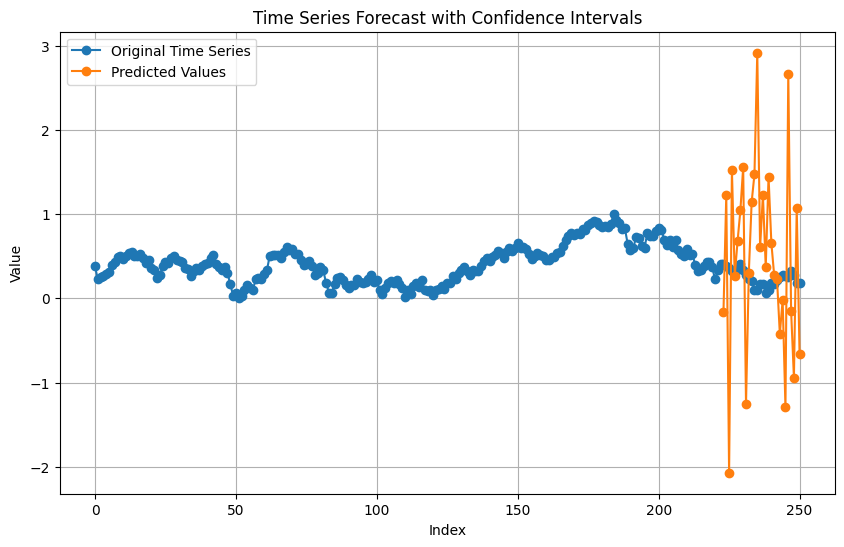

In [147]:
import matplotlib.pyplot as plt
import pandas as pd
from pyro.infer import Predictive

# Assuming `model` and `mcmc` are defined earlier

# Define your model, initialize MCMC, and run MCMC as shown in your previous code

# Assuming `X` contains your test features
x_test = torch.from_numpy(X_test).float()  # Features
print(X_test.shape)
print(y_test.shape)
# Create a predictive instance using the trained model and posterior samples
predictive = Predictive(model, guide=mean_field_guide, num_samples=500)
preds = predictive(x_test)
# Extract the mean predictions
mean_preds = preds['obs'].mean(dim=0)

std_preds = preds['obs'].std(dim=0) 

print(mean_preds.shape)
print(y_test.shape)
print(std_preds.shape)
print(mean_preds)
print(y_test)

import matplotlib.pyplot as plt

print(mean_preds[0].shape)
print(y_test.shape)
print(std_preds.shape)

# Convert the time date column to indexes
data_close.index = range(len(data_close))

# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(data_close.index, data_close.values, marker='o', linestyle='-', label='Original Time Series')

# Plot the predicted values
x_pred = range(len(data_close), len(data_close) + len(mean_preds))
plt.plot(data_close.index[-len(mean_preds[0]):], mean_preds[0], marker='o', linestyle='-', label='Predicted Values')

# Plot the confidence regions
#plt.fill_between(data_close.index[-len(mean_preds[0]):], mean_preds[0] - 2 * std_preds[0], mean_preds[0] + 2 * std_preds[0], alpha=0.6, color='#86cfac', label='Confidence Region')

# Add labels and legend
plt.title('Time Series Forecast with Confidence Intervals')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Show plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt

print(mean_preds[0].shape)
print(y_test.shape)
print(std_preds.shape)

# Convert the time date column to indexes
data_close.index = range(len(data_close))

# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(data_close.index, data_close.values, marker='o', linestyle='-', label='Original Time Series')

# Plot the predicted values
x_pred = range(len(data_close), len(data_close) + len(y_pred_mean))
plt.plot(data_close.index[-len(mean_preds[0]):], mean_preds[0], marker='o', linestyle='-', label='Predicted Values')

# Plot the confidence regions
#plt.fill_between(data_close.index[-len(mean_preds[0]):], mean_preds[0] - 2 * std_preds[0], mean_preds[0] + 2 * std_preds[0], alpha=0.6, color='#86cfac', label='Confidence Region')

# Add labels and legend
plt.title('Time Series Forecast with Confidence Intervals')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [ ]:
print(data_close)

# Plot the predictions
y_test_vec = y_test[0]
y_pred_mean = mean_preds[0]
y_pred_std = std_preds[0]
x = len(y_test_vec)

plt.figure(figsize=(10, 6))
plt.plot(y_pred_vec, marker='o', linestyle='-', label='Predictions')
plt.plot(y_test_vec, marker='x', linestyle='-', label='True Values')  # Plot y_test
plt.fill_between(x, y_pred_mean - 2 * y_pred_std, y_pred_mean + 2 * y_pred_std, alpha=0.6, color='#86cfac', zorder=5)

# Add labels and legend
plt.title('Predictions vs True Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def plot_predictions(preds):
    y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
    y_std = preds['obs'].T.detach().numpy().std(axis=1)

    fig, ax = plt.subplots(figsize=(10, 5))

    ax.plot(x_true, y_true, 'b-', linewidth=3, label="true function")
    ax.plot(x_obs, y_obs, 'ko', markersize=4, label="observations")
    ax.plot(x_obs, y_obs, 'ko', markersize=3)
    ax.plot(x_test, y_pred, '-', linewidth=3, color="#408765", label="predictive mean")
    ax.fill_between(x_test, y_pred - 2 * y_std, y_pred + 2 * y_std, alpha=0.6, color='#86cfac', zorder=5)

    plt.legend(loc=4, fontsize=15, frameon=False)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from pyro.infer import Predictive

# Extracting mean and standard deviation from the predictive samples
mean_preds = preds['obs'].mean(dim=0)
std_preds = preds['obs'].std(dim=0)

mean_preds = mean_preds[0]
std_preds = std_preds[0]

print(mean_preds.shape)
print(std_preds.shape)
print(X.shape)

# Convert the index to datetime if it's not already in datetime format
timeseries.index = pd.to_datetime(timeseries.index)[-7:0
print(timeseries.index)

# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(timeseries.index, timeseries.values, marker='o', linestyle='-', label='Actual')

# Plot the predictions and confidence intervals
plt.plot(timeseries.index, mean_preds, color='red', linestyle='-', label='Predictions')
plt.fill_between(timeseries.index, mean_preds - 2 * std_preds, mean_preds + 2 * std_preds, color='red', alpha=0.2)

plt.title('Time Series Plot with Predictions')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert the index to datetime if it's not already in datetime format
timeseries.index = pd.to_datetime(timeseries.index)
print(timeseries.index.shape)

# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(timeseries.index, timeseries.values, marker='o', linestyle='-')
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

In [ ]:
class MyBNN2(PyroModule):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.linear1 = PyroModule[nn.Linear](input_dim, hidden_dim)
        self.linear1.weight = PyroSample(dist.Normal(0., 1.).expand([hidden_dim, input_dim]).to_event(2))
        self.linear1.bias = PyroSample(dist.Normal(0., 1.).expand([hidden_dim]).to_event(1))
        self.activation = nn.Tanh() # nn.ReLU()
        self.linear2 = PyroModule[nn.Linear](hidden_dim, output_dim)
        self.linear2.weight = PyroSample(dist.Normal(0., 1.).expand([output_dim, hidden_dim]).to_event(2))
        self.linear2.bias = PyroSample(dist.Normal(0., 1.).expand([output_dim]).to_event(1))

    def forward(self, x, y=None):
        mu = self.linear2(self.linear1(x)).squeeze(-1)
        print(mu.shape)
        # Sample sigma within the plate context to match the shape of mu
        with pyro.plate("data", x.shape[0]):
            sigma = pyro.sample("sigma", dist.Gamma(0.5, 1.).expand([x.shape[0], mu.shape[1]]))
            print(sigma.shape)
            obs = pyro.sample("obs", dist.Normal(mu, sigma), obs=y)
        return mu


In [ ]:
# Convert data to PyTorch tensors
x_train = torch.from_numpy(lagged_training_values[1:]).float().T  # Features
y_train = torch.from_numpy(lagged_training_values[0]).float()  # Target

print(x_train.shape)
print(y_train.shape)

# Instantiate the BNN model
input_dim = x_train.shape[1]  # Number of lagged features
hidden_dim = 10  # Number of hidden units
output_dim = 1  # Output dimension

model = MyBNN(input_dim, hidden_dim, output_dim)

# Set Pyro random seed
pyro.set_rng_seed(42)

# Define Hamiltonian Monte Carlo (HMC) kernel
nuts_kernel = NUTS(model)

# Define MCMC sampler, get 50 posterior samples
mcmc = MCMC(nuts_kernel, num_samples=50)

# Run MCMC
# mcmc.run(x_train, y_train)

# Access posterior samples
#posterior_samples = mcmc.get_samples()

In [ ]:
## old template
class MyFirstBNN(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, hid_dim=5, prior_scale=10.):
        super().__init__()

        self.activation = nn.Tanh()  # or nn.ReLU()
        self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)  # Input to hidden layer
        self.layer2 = PyroModule[nn.Linear](hid_dim, out_dim)  # Hidden to output layer

        # Set layer parameters as random variables
        self.layer1.weight = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim, in_dim]).to_event(2))
        self.layer1.bias = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim]).to_event(1))
        self.layer2.weight = PyroSample(dist.Normal(0., prior_scale).expand([out_dim, hid_dim]).to_event(2))
        self.layer2.bias = PyroSample(dist.Normal(0., prior_scale).expand([out_dim]).to_event(1))

    def forward(self, x, y=None):
        x = x.reshape(-1, 1)
        x = self.activation(self.layer1(x))
        mu = self.layer2(x).squeeze()
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))  # Infer the response noise

        # Sampling model
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma), obs=y)
        return mu

In [ ]:
from pyro.infer import Predictive

predictive = Predictive(model=model, posterior_samples=mcmc.get_samples())
x_test = torch.from_numpy(lagged_values[1:]).float().T
preds = predictive(x_test)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from pyro.infer import Predictive

# Define the plot_predictions function
def plot_predictions(y_pred_mean, y_pred_std, values):
    # Plot the original time series
    plt.figure(figsize=(20, 4))
    plt.plot(values, label='Original Time Series')
    
    # Plot the predicted values with confidence regions
    plt.plot(np.arange(len(values)-len(y_pred_mean), len(values) ), y_pred_mean, label='Predicted Mean')
    plt.fill_between(np.arange(len(values)-len(y_pred_mean), len(values) ),
                     y_pred_mean - 2 * y_pred_std,
                     y_pred_mean + 2 * y_pred_std,
                     color='gray', alpha=0.3, label='Confidence Region')
    
    plt.ylabel('Value')
    plt.xlabel('Time')
    plt.legend()
    plt.show()

# Calculate and plot the predictive distribution
#predictive = Predictive(model=model, posterior_samples=mcmc.get_samples())
#x_test = torch.from_numpy(lagged_values[1:]).float().T
#preds = predictive(x_test)

# Extract mean and standard deviation from the predictive distribution
y_pred_mean = preds['obs'].detach().numpy().mean(axis=0)
y_pred_std = preds['obs'].detach().numpy().std(axis=0)

# Plot the predictions
print(y_pred_mean.shape)
print(y_pred_std.shape)
plot_predictions(y_pred_mean[0], y_pred_std[0], timeseries)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from pyro.infer import Predictive

# Define the plot_predictions function
def plot_predictions(y_pred_mean, y_pred_std, values):
    # Plot the original time series
    plt.figure(figsize=(20, 4))
    plt.plot(values, label='Original Time Series')
    
    # Plot the predicted values with confidence regions
    plt.plot(np.arange(len(values)-len(y_pred_mean), len(values) ), y_pred_mean, label='Predicted Mean')
    plt.fill_between(np.arange(len(values)-len(y_pred_mean), len(values) ),
                     y_pred_mean - 2 * y_pred_std.squeeze(),  # Squeeze to convert to 1D array
                     y_pred_mean + 2 * y_pred_std.squeeze(),
                     color='gray', alpha=0.3, label='Confidence Region')
    
    plt.ylabel('Value')
    plt.xlabel('Time')
    plt.legend()
    plt.show()

# Example usage:
# predictive = Predictive(model=model, posterior_samples=mcmc.get_samples())
# x_test = torch.from_numpy(lagged_values[1:]).float().T
# preds = predictive(x_test)

# Extract mean and standard deviation from the predictive distribution
y_pred_mean = preds['obs'].detach().numpy().mean(axis=0)
y_pred_std = preds['obs'].detach().numpy().std(axis=0)

# Plot the predictions
print(y_pred_mean)
print(y_pred_std)
plot_predictions(y_pred_mean, y_pred_std, values)


In [ ]:
np.arange(len(values), len(values) + len(y_pred_mean))
len(y_pred_mean)

In [ ]:
def plot_predictions(preds):
    y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
    y_std = preds['obs'].T.detach().numpy().std(axis=1)

    fig, ax = plt.subplots(figsize=(10, 5))
    plt.figure(figsize=(20, 4))
    plt.plot(values)
    plt.ylabel('Value')
    plt.xlabel('Time')
    None


    ax.plot(x_true, y_true, 'b-', linewidth=3, label="true function")
    ax.plot(x_obs, y_obs, 'ko', markersize=4, label="observations")
    ax.plot(x_obs, y_obs, 'ko', markersize=3)
    ax.plot(x_test, y_pred, '-', linewidth=3, color="#408765", label="predictive mean")
    ax.fill_between(x_test, y_pred - 2 * y_std, y_pred + 2 * y_std, alpha=0.6, color='#86cfac', zorder=5)

    plt.legend(loc=4, fontsize=15, frameon=False)

plot_predictions(preds)

In [ ]:
np.arange(len(values) - len(y_pred_mean), len(values))

In [ ]:
x_train[-1].clone().detach()

In [ ]:
# Define a function to predict future values iteratively
def predict_future(model, mcmc, x_train, num_steps):
    # Initialize an empty array to store predicted values
    predicted_values = []

    # Initialize the last known values with the last k values of x_train
    last_known_values = x_train[-1].clone().detach()

    for step in range(num_steps):
        # Predict the mean and standard deviation for the next time step
        predictive = Predictive(model=model, posterior_samples=mcmc.get_samples())
        preds = predictive(last_known_values)

        # Extract the mean from the predictive distribution
        y_pred_mean = preds['obs'].detach().numpy().mean(axis=0)

        # Append the predicted mean to the list of predicted values
        predicted_values.append(y_pred_mean[-1])

        # Update the last known values with the predicted value and the previous known values
        last_known_values = torch.cat([last_known_values[1:], torch.tensor([y_pred_mean[-1]])])
        print(last_known_values)
        print(predicted_values)
    return predicted_values

# Define the number of future steps to predict
num_steps = 200  # Adjust this as needed

# Predict future values iteratively
predicted_values = predict_future(model, mcmc, x_train, num_steps)

# Plot the original time series and the predicted future values
plt.figure(figsize=(20, 4))
plt.plot(values, label='Original Time Series')
plt.plot(np.arange(len(values), len(values) + num_steps), predicted_values, label='Predicted Future Values')
plt.ylabel('Value')
plt.xlabel('Time')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Define a function to make predictions using the trained model
def predict(model, lagged_test_values):
    x_test = torch.from_numpy(lagged_test_values[1:]).float().T  # Features
    with torch.no_grad():
        y_pred = model(x_test).numpy()  # Predictions
    return y_pred

# Make predictions using the trained model
predictions = predict(model, lagged_test_values)

# Plot the original time series data
plt.figure(figsize=(20, 4))
plt.plot(values, label='Original Data')

# Plot the predicted values
n_train = len(values) // 2
plt.plot(np.arange(n_train + max_lag, len(values)), predictions, label='Predicted Data', linestyle='--')

plt.ylabel('Value')
plt.xlabel('Time')
plt.legend()
plt.show()


In [ ]:

predictive = Predictive(model=model, posterior_samples=mcmc.get_samples())
x_test = torch.linspace(xlims[0], xlims[1], 3000)
preds = predictive(x_test)

In [ ]:
print(lagged_training_values[0].shape)
print(lagged_training_values[1:].shape)

In [ ]:
model = MyFirstBNN(in_dim=max_lag)

# Set Pyro random seed
pyro.set_rng_seed(42)

# Define Hamiltonian Monte Carlo (HMC) kernel
# NUTS = "No-U-Turn Sampler" (https://arxiv.org/abs/1111.4246), gives HMC an adaptive step size
nuts_kernel = NUTS(model, jit_compile=False)  # jit_compile=True is faster but requires PyTorch 1.6+

# Define MCMC sampler, get 50 posterior samples
mcmc = MCMC(nuts_kernel, num_samples=50)

# Convert data to PyTorch tensors
x_train = torch.from_numpy(lagged_training_values[1:]).float()
y_train = torch.from_numpy(lagged_training_values[0]).float()

# Run MCMC
mcmc.run(x_train, y_train)

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Generate data
x_obs = np.hstack([np.linspace(-0.2, 0.2, 500), np.linspace(0.6, 1, 500)])
noise = 0.02 * np.random.randn(x_obs.shape[0])
y_obs = x_obs + 0.3 * np.sin(2 * np.pi * (x_obs + noise)) + 0.3 * np.sin(4 * np.pi * (x_obs + noise)) + noise

x_true = np.linspace(-0.5, 1.5, 1000)
y_true = x_true + 0.3 * np.sin(2 * np.pi * x_true) + 0.3 * np.sin(4 * np.pi * x_true)

# Set plot limits and labels
xlims = [-0.5, 1.5]
ylims = [-1.5, 2.5]

# Create plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x_true, y_true, 'b-', linewidth=3, label="True function")
ax.plot(x_obs, y_obs, 'ko', markersize=4, label="Observations")
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_xlabel("X", fontsize=30)
ax.set_ylabel("Y", fontsize=30)
ax.legend(loc=4, fontsize=15, frameon=False)

plt.show()

print(x_obs.shape)
print(y_obs.shape)

x_train = torch.from_numpy(x_obs).float()
y_train = torch.from_numpy(y_obs).float()
print(x_train.shape)
print(y_train.shape)

x_train = torch.from_numpy(lagged_training_values[1:]).float()
y_train = torch.from_numpy(lagged_training_values[0]).float()
print(x_train.shape)
print(y_train.shape)

In [ ]:
def log_likelihood(lagged_values, weights):
    # The data to predict is the current observation (lag 0)
    target = lagged_values[0]
    # The features used are the past observations (lag 1 to lag k)
    inputs = lagged_values[1:len(weights)+1]
    
    # Prediction for a linear model
    preds = inputs.T @ weights
    
    # Residual sum of squares
    rss = np.sum((target - preds)**2)
    
    # Log-likelihood
    return - 0.5 * len(target) * np.log(rss)